In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import RoutingClient
from obspy import Stream
from obspy.geodetics import gps2dist_azimuth
from obspy import signal
from obspy import read
import matplotlib.pyplot as plt
import folium
import numpy as np
import json
import pandas as pd
from obspy.clients.fdsn.header import FDSNNoDataException
from scipy.signal import savgol_filter
import os
import folium
import numpy as np
import branca.colormap as cm

from obspy import Stream
from matplotlib.colors import LogNorm

import pandas as pd

Dtmin_Noise=-25
Dtmax_Noise=-5
Dtmin_Pn=-5.
Dtmax_Pn=10.
Dtmin_Sn=-5.
Dtmax_Sn=10.

vLg_max=3.5
vLg_min=3.1
vLg=0.5*(vLg_max+vLg_min)
vPg_max=6.2
vPg_min=5.2
vPg=0.5*(vPg_max+vPg_min)
print(vPg)
#vPg=6.

tminCoda=300.
tmaxCoda=320.

5.7


In [2]:
from new_functions import get_data2, big_downloader2, calc_amps, plot_stations_amps, plot_record_section, SNR_all, select_ratio, select_ratio_dict, update_event_file

/home/schreinl/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To do: 
- plot the enevelopes

<class 'numpy.ndarray'>


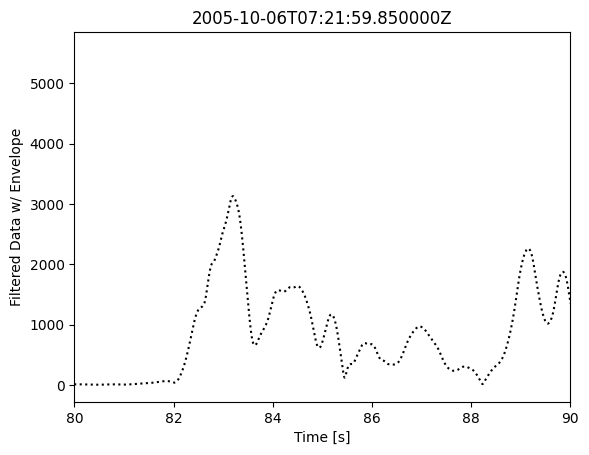

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
import obspy.signal


st = obspy.read("https://examples.obspy.org/RJOB_061005_072159.ehz.new")
data = st[0].data
npts = st[0].stats.npts
samprate = st[0].stats.sampling_rate

# Filtering the Stream object
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=1, freqmax=3, corners=2, zerophase=True)

# Envelope of filtered data
data_envelope = obspy.signal.filter.envelope(st_filt[0].data)
print(type(data_envelope))

# The plotting, plain matplotlib
t = np.arange(0, npts / samprate, 1 / samprate)
#plt.plot(t, st_filt[0].data, 'k')
plt.plot(t, data_envelope, 'k:')
plt.title(st[0].stats.starttime)
plt.ylabel('Filtered Data w/ Envelope')
plt.xlabel('Time [s]')
plt.xlim(80, 90)
plt.show()

#### Choose large earthquakes


In [4]:

catalogue_5 = pd.read_csv('/home/schreinl/Stage/Data/eq_4_france.csv')
catalogue_5 = catalogue_5[catalogue_5['mag'] >= 4.5].reset_index(drop=True)
print(len(catalogue_5))
carte = folium.Map([45, 7], zoom_start=5)

for _, row in catalogue_5.iterrows():
    infos = f"{row['time']} ({row['latitude']}, {row['longitude']}) {row['mag']} m"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        tooltip=infos,
        fill=True,
        fill_opacity=1.0,
        radius=4,
    ).add_to(carte)

carte


45


In [7]:
datacenters =['RESIF','ODC','ETH','INGV','GEOFON', 'IRIS', 'ICGC']#,'BGR']
directory='/home/schreinl/Stage/Data/'
distmin=1.9
distmax=10.
start = UTCDateTime(catalogue_5['time'][5])
end = start + 700
eq_lon = float(catalogue_5['longitude'][5])
eq_lat = float(catalogue_5['latitude'][5])
st_all, stations_all, plot = big_downloader2(datacenters, start, end, eq_lon, eq_lat, distmin, distmax, directory, plot=False)
time_string = UTCDateTime.strftime(start, format="%Y_%m_%dT%H_%M_%S")


Earthquake at 2022-03-12T17:03:22.558000Z with magnitude 4.5


Processing stations of RESIF:   5%|▍         | 10/208 [00:00<00:02, 93.51it/s]/home/schreinl/.local/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
Processing stations of ODC:  20%|█▉        | 37/188 [00:02<00:09, 16.53it/s]/home/schreinl/.local/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
Processing stations of ODC:  43%|████▎     | 80/188 [00:30<02:00,  1.12s/it] WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
Processing stations of ETH:   0%|          | 0/78 [00:00<?, ?it/s]/home/schreinl/.local/lib/python3.10/site-packages/obspy/io/mseed/core.py:773: UserW

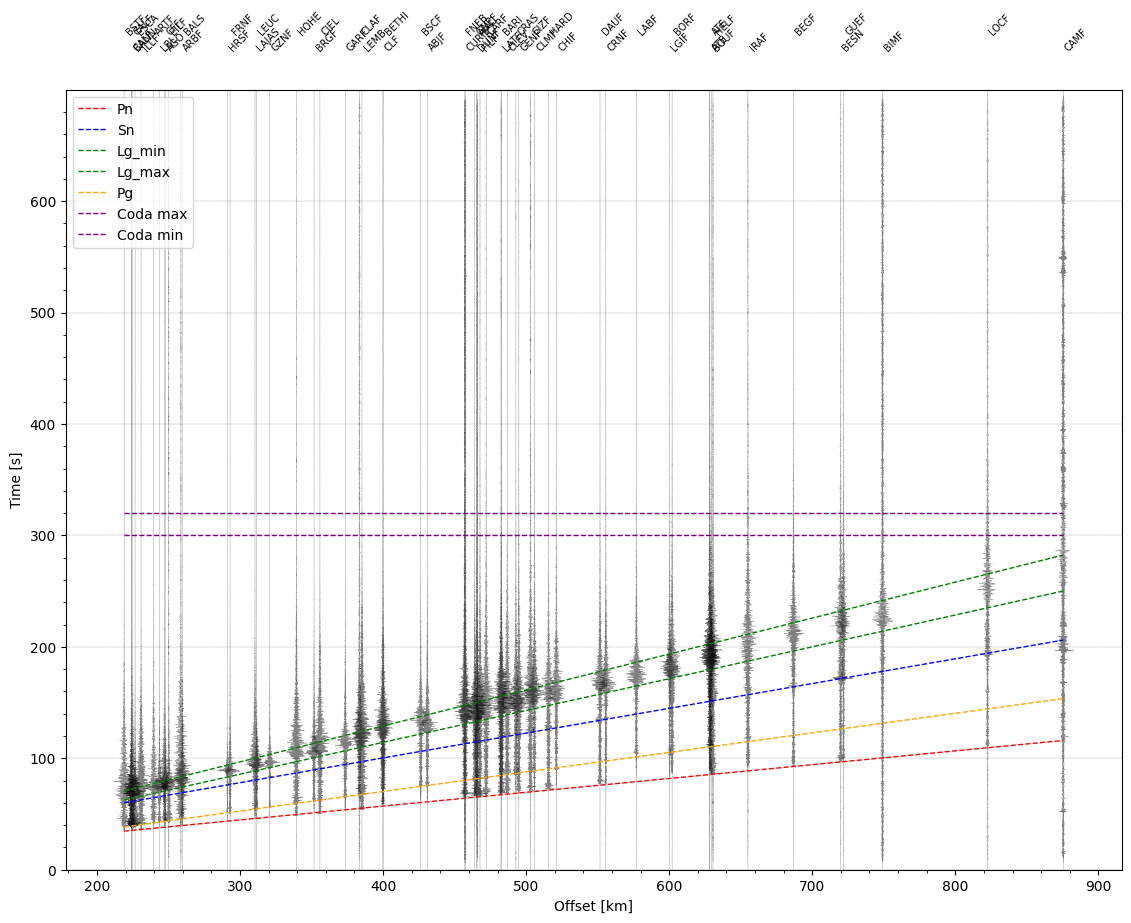

In [8]:
st_plot_filt_all=st_all.copy()
fmin=1
fmax=5
st_plot_filt_all.filter("bandpass", freqmin=fmin, freqmax=fmax)


plot, st_Lg0 = plot_record_section(st_plot_filt_all[0:60], stations_all[0:60], eq_lat, 
eq_lon, start, tracehodo=True, v_Lg_min=vLg_min, v_Lg_max=vLg_max, 
v_Pg=vPg)

In [9]:
print(len(st_plot_filt_all))

722


Choose now one station for a large event, plot the envelope and find the linear regime in the decay.
Then several stations can be plotted, the ratio and the coda amplitude ratio.


In [10]:
import obspy
from scipy.fftpack import hilbert
import numpy as np
#from obspy.signal.filter import envelope
from scipy.signal import resample


def envelope(data):
    hilb = hilbert(data)
    data = (data ** 2 + hilb ** 2) ** 0.5
    return data

st_envelope = obspy.Stream()
smallest = 7000
for tr in st_plot_filt_all:
    data_envelope = envelope(tr.data)
    npts = tr.stats.npts
    if npts >= smallest:
        samprate = tr.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)
        tr_envelope = obspy.Trace(data=data_envelope, header=tr.stats)
        #data_resampled = resample(tr_envelope.data, 10000)
        #tr_resampled = obspy.Trace(data=data_resampled, header=tr.stats)
        st_envelope.append(tr_envelope)
#st_envelope.write(f'/home/schreinl/Stage/Data/Envelopes/{time_string}_envelopes.mseed')





In [14]:
print(st_envelope[11].stats.station) #CI19 good for La Rochelle event

BESN


11


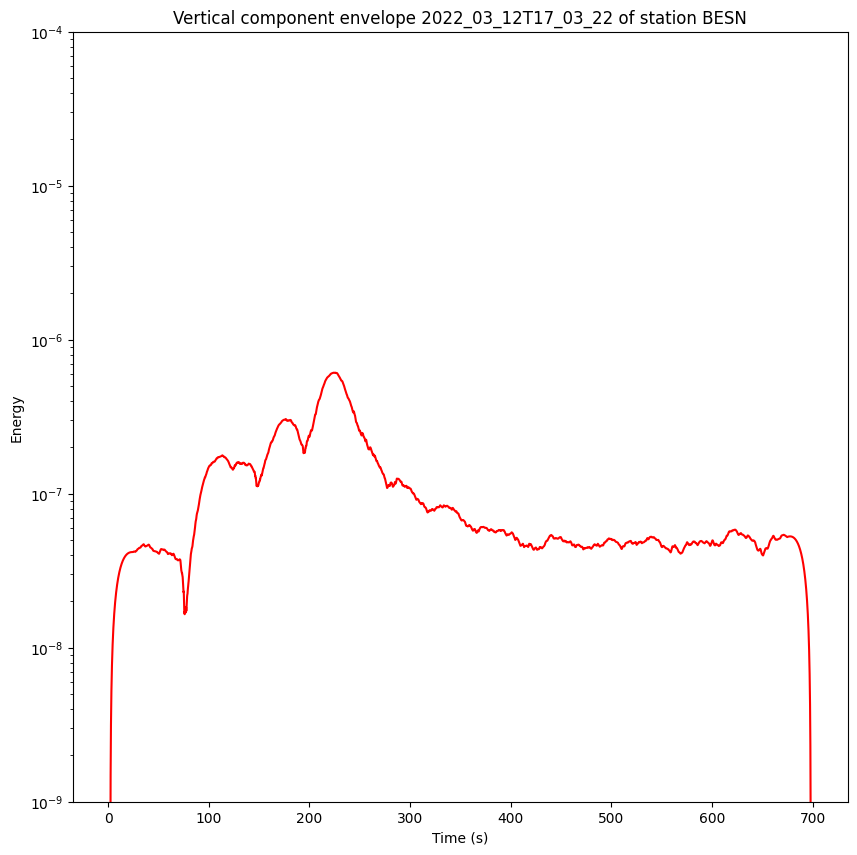

In [15]:
station = "BESN"
plt.figure(figsize=(10,10))
for i,tr in enumerate(st_envelope):
    if tr.stats.station == station:
        idx_reference = i
        print(i)
        npts = len(tr.data)
        samprate = tr.stats.sampling_rate #10000/700 
        t = np.arange(0, npts / samprate, 1 / samprate)

        #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
        
        window_length = 50*samprate #min(2000, npts)
        if window_length % 2 == 0:
            window_length -= 1
        yhat = savgol_filter(tr.data, int(window_length), 3) 
        t = t[:len(yhat)]
        plt.title(f"Vertical component envelope {time_string} of station {station}")
        plt.ylabel("Energy")
        plt.xlabel("Time (s)")
        #plt.semilogy(t,st_envelope[i])
        plt.semilogy(t,yhat, color='red')
        plt.ylim([1e-9,1e-4])
        #plt.xlim([100,350])
plt.show()


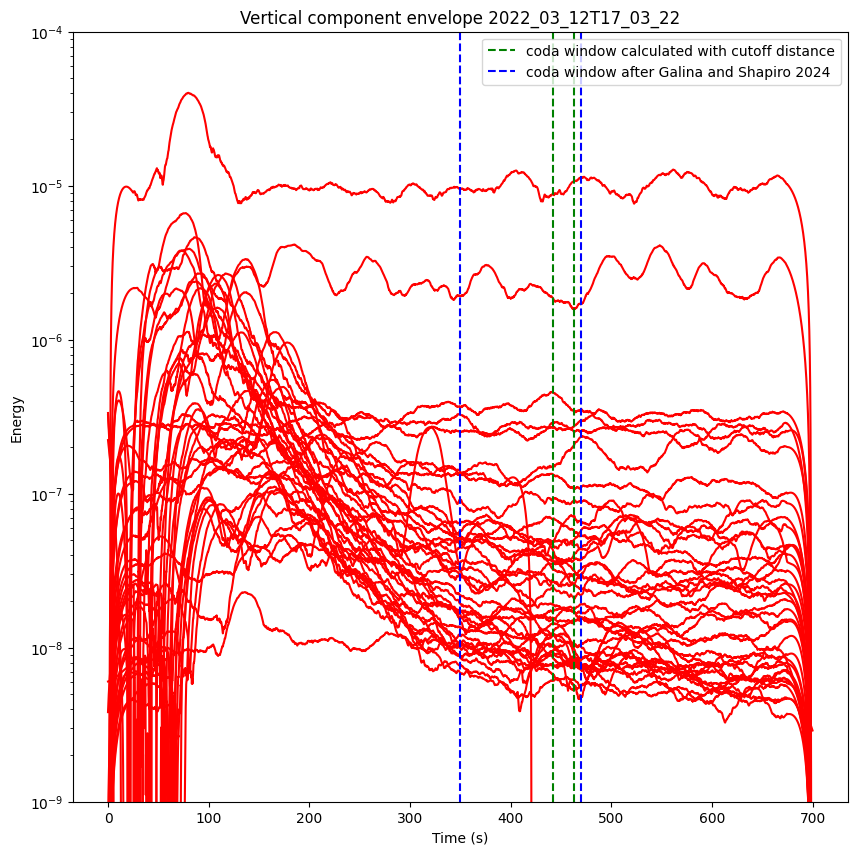

In [17]:
from scipy.signal import savgol_filter
from random import randint
def smooth_plot_envelope(time_string, n_traces,st_envelope):
    testing = [(randint(1, len(st_plot_filt_all))) for i in range(n_traces)]

    plt.figure(figsize=(10,10))
    for i in testing:
        if i < len(st_envelope):
            npts = len(st_envelope[i].data)
            samprate = st_envelope[i].stats.sampling_rate #10000/700 
            t = np.arange(0, npts / samprate, 1 / samprate)

            #use a stable window length in s, while the window lenght in samples is dependant on the sample rate
            
            window_length = min(50*samprate, npts) # Ensure window_length is not greater than npts
            if window_length % 2 == 0:
                window_length -= 1
            yhat = savgol_filter(st_envelope[i].data, int(window_length), 3) 
            t = t[:len(yhat)]

            #plt.semilogy(t,st_envelope[i])
            plt.semilogy(t,yhat, color='red')
            plt.ylim([1e-9,1e-4])
            plt.title(f"Vertical component envelope {time_string}")
            plt.ylabel("Energy")
            plt.xlabel("Time (s)")
            #plt.xlim([100,350])
    plt.vlines(442.5923911439157,ymax=1e-4,ymin=1e-9, label='coda window calculated with cutoff distance',colors='g',linestyles='--')
    plt.vlines(462.5923911439157,ymax=1e-4,ymin=1e-9,colors='g',linestyles='--')
    plt.vlines(350,ymax=1e-4,ymin=1e-9, label='coda window after Galina and Shapiro 2024',colors='b',linestyles='--')
    plt.vlines(470,ymax=1e-4,ymin=1e-9,colors='b',linestyles='--')
    plt.legend()
    plt.show()

    return  
tset = smooth_plot_envelope(time_string, 50,st_envelope)

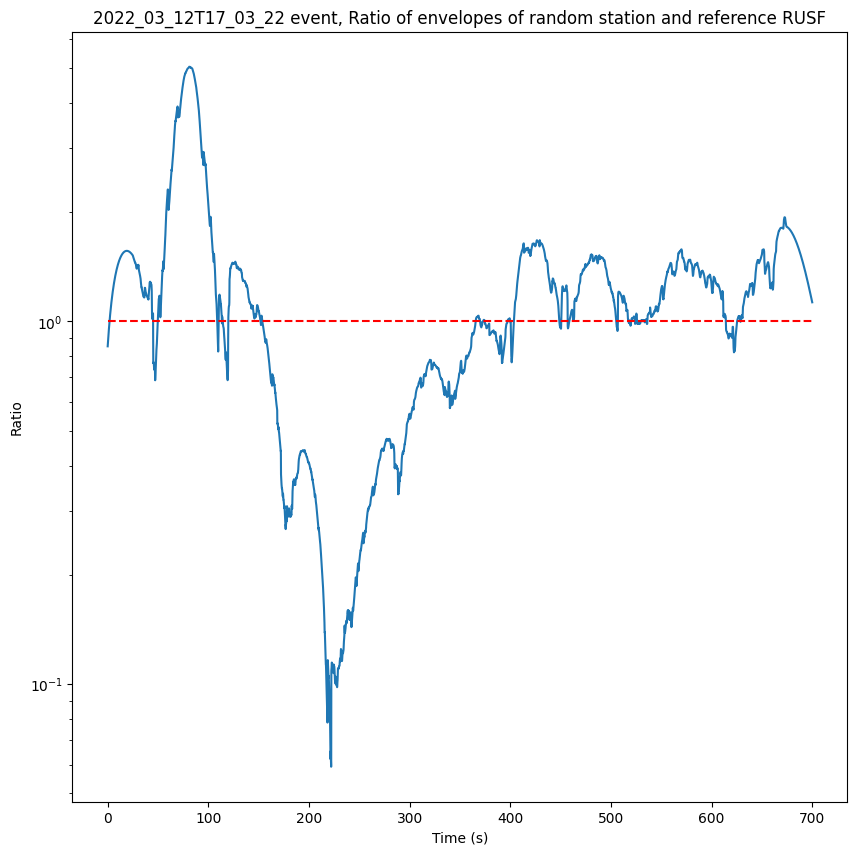

In [18]:
plt.figure(figsize=(10,10))
plt.semilogy(np.arange(0,700,0.01),savgol_filter(np.divide(resample(st_envelope[98].data,70000),resample(st_envelope[idx_reference].data,70000)),5000,3))
plt.title(f"{time_string} event, Ratio of envelopes of random station and reference RUSF")
plt.xlabel('Time (s)')
plt.ylabel('Ratio')
plt.hlines(1,xmin=0,xmax=700, linestyles="--",colors='r')

#### Routine
Now implement a routine, which, for a given event, gets the data, filters it, calculates the envelope for each trace and writes it in a stream. Then a second stream is initialised, where all the envelopes are smoothed. These streams can be written to disk. Plot the coda amplitude ratio (from disk) of all stations in relation to the same station, and the envelope ratio with the same ratio against each other. Then plot the coda amp ratio of a specific ratio over magnitudes. 

For the amplitude ratios, choose a time window of length 120s, then calculate the amplitude ratio and its mean.

In [18]:
import numpy as np
import obspy
from scipy.signal import savgol_filter

def envelopes_routine(event, st_envelope, ref_idx, codastart=350, codaend=470, plotting=False, n_traces=50):
    '''
    Takes as input a stream with the envelopes. It subsequently calculates the smoothed envelopes with a moving averaging
    window of 50s. These smooth envelopes are put in a new stream.
    
    '''
    st_envelope_smooth = obspy.Stream()
    
    for trace in st_envelope:
        npts = len(trace.data)
        samprate = trace.stats.sampling_rate  # Example: 10000/700
        t = np.arange(0, npts / samprate, 1 / samprate)

        # Define stable window length
        window_length = min(50 * samprate, npts)  # Ensure window_length is not greater than npts
        if window_length % 2 == 0:
            window_length -= 1
        
        # Smooth the envelope using Savitzky-Golay filter
        yhat = savgol_filter(trace.data, int(window_length), 3) 
        t = t[:len(yhat)]

        # Create a new Trace with smoothed data
        tr_envelope_smooth = obspy.Trace(data=yhat, header=trace.stats)
        st_envelope_smooth.append(tr_envelope_smooth)

    if plotting:
        smooth_plot_envelope(event, n_traces, st_envelope_smooth)

    # Calculate mean amplitude ratio
    station_ratio_amps = np.zeros((2, len(st_envelope_smooth)))

    for j, trace in enumerate(st_envelope_smooth):
        dt = trace.stats.delta
        startcoda = int(codastart / dt)  # Convert time to sample index
        endcoda = int(codaend / dt)      # Convert time to sample index

        # Ensure indices are within bounds
        if startcoda >= len(trace.data) or endcoda > len(trace.data):
            continue
        
        # Extract coda window
        coda = trace.data[startcoda:endcoda]
        ref = st_envelope_smooth[ref_idx].data[startcoda:endcoda]

        # Compute mean amplitude ratio
        station_ratio_amps[0, j] = j  # Storing index instead of station name
        station_ratio_amps[1, j] = (np.sqrt(np.dot(coda, coda.T)) / len(coda)) / \
                                   (np.sqrt(np.dot(ref, ref.T)) / len(ref))

    return station_ratio_amps

test = envelopes_routine(time_string, st_envelope, ref_idx=1, plotting=False)
print(test)


[[0.00000000e+00 1.00000000e+00 2.00000000e+00 3.00000000e+00
  4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00
  8.00000000e+00 9.00000000e+00 1.00000000e+01 1.10000000e+01
  1.20000000e+01 1.30000000e+01 1.40000000e+01 1.50000000e+01
  1.60000000e+01 1.70000000e+01 1.80000000e+01 1.90000000e+01
  2.00000000e+01 2.10000000e+01 2.20000000e+01 2.30000000e+01
  2.40000000e+01 2.50000000e+01 2.60000000e+01 2.70000000e+01
  2.80000000e+01 2.90000000e+01 3.00000000e+01 3.10000000e+01
  3.20000000e+01 3.30000000e+01 3.40000000e+01 3.50000000e+01
  3.60000000e+01 3.70000000e+01 3.80000000e+01 3.90000000e+01
  4.00000000e+01 4.10000000e+01 4.20000000e+01 4.30000000e+01
  4.40000000e+01 4.50000000e+01 4.60000000e+01 4.70000000e+01
  4.80000000e+01 4.90000000e+01 5.00000000e+01 5.10000000e+01
  5.20000000e+01 5.30000000e+01 5.40000000e+01 5.50000000e+01
  5.60000000e+01 5.70000000e+01 5.80000000e+01 5.90000000e+01
  6.00000000e+01 6.10000000e+01 6.20000000e+01 6.30000000e+01
  6.4000

/tmp/ipykernel_3983/1617463014.py:53: RuntimeWarning: invalid value encountered in scalar divide
  (np.sqrt(np.dot(ref, ref.T)) / len(ref))


In [19]:

import numpy as np
import obspy
from scipy.signal import savgol_filter

def envelopes_routine(event, st_envelope, ref_idx, codastart=350, codaend=470, plotting=False, n_traces=50):
    '''
    Takes as input a stream with the envelopes. It subsequently calculates the smoothed envelopes with a moving averaging
    window of 50s. These smooth envelopes are put in a new stream.
    
    '''
    st_envelope_smooth = obspy.Stream()
    
    for trace in st_envelope:
        npts = len(trace.data)
        samprate = trace.stats.sampling_rate
        t = np.arange(0, npts / samprate, 1 / samprate)

        window_length = min(50 * samprate, npts) 
        if window_length % 2 == 0:
            window_length -= 1
        
        yhat = savgol_filter(trace.data, int(window_length), 3) 
        t = t[:len(yhat)]

        tr_envelope_smooth = obspy.Trace(data=yhat, header=trace.stats)
        st_envelope_smooth.append(tr_envelope_smooth)

    if plotting:
        smooth_plot_envelope(event, n_traces, st_envelope_smooth)

    station_ratios = {}

    for trace in st_envelope_smooth:
        dt = trace.stats.delta
        startcoda = int(codastart / dt) 
        endcoda = int(codaend / dt) 
        if startcoda >= len(trace.data) or endcoda > len(trace.data):
            continue

        coda = trace.data[startcoda:endcoda]
        ref = st_envelope_smooth[ref_idx].data[startcoda:endcoda]

        station_name = trace.stats.station 
        #amplitude_ratio = (np.sqrt(np.dot(coda, coda.T)) / len(coda)) / \
        #                  (np.sqrt(np.dot(ref, ref.T)) / len(ref))
        amplitude = (np.sqrt(np.dot(coda, coda.T)) / len(coda))
        
        station_ratios[station_name] = amplitude

    return station_ratios

envelopes_amps = envelopes_routine(time_string, st_envelope, ref_idx=idx_reference, plotting=False)
print(envelopes_amps)


{'ABJF': 1.8528896552835813e-10, 'AGO': 1.6912538043108968e-10, 'AJAC': 4.2983049823247717e-10, 'ARBF': 1.2336909612160449e-09, 'ARTF': 1.3605300290789122e-09, 'ATE': 2.3474024549872633e-10, 'BALS': 4.441337307993451e-10, 'BANN': 1.9421588659399224e-10, 'BARI': 1.0592416772803956e-09, 'BEGF': 3.433923193127123e-10, 'BESN': 4.855072732828605e-10, 'BETHI': 2.1263303187099866e-10, 'BIMF': 9.049333090924266e-10, 'BORF': 1.7994515381449375e-10, 'BOUF': 2.841357300993995e-10, 'BRGF': 1.7154271854581967e-10, 'BSCF': 3.8368639627704973e-10, 'BSTF': 7.669806520816516e-10, 'CALF': 5.992909049658704e-10, 'CAMF': 1.2313115188330087e-09, 'CARF': 6.071330303594178e-10, 'CFF': 4.589806603739845e-09, 'CHIF': 4.2272778497894567e-10, 'CIEL': 6.31850713526385e-10, 'CLAF': 9.157753037224045e-10, 'CLEV': 8.724248089439327e-10, 'CLF': 7.611853787811242e-10, 'CLMF': 4.789226182532306e-10, 'CRAS': 2.58221094408848e-10, 'CRNF': 2.435718327959704e-10, 'CURIE': 3.5101024121187535e-09, 'DAUF': 2.430978408985278e-

In [20]:
snr_threshold = 2
eq_start = start

filtered_stations_with_SNR, stations_with_SNR, distance_dict, tcoda_test, filtered_st, stations_with_amps, amp_plot = SNR_all(stations_all, st_plot_filt_all, Dtmin_Pn, Dtmax_Pn, Dtmin_Sn, Dtmax_Sn, vLg_min,vLg_max,vPg_min, vPg_max, tminCoda, tmaxCoda,
         Dtmin_Noise, Dtmax_Noise,eq_start,eq_lat,eq_lon,snr_threshold=snr_threshold,plot_SNR=False,plot_amps=True, wavecode="Lg_Coda",dB=True)


with open(f"{directory}/Dicts/{time_string}_{snr_threshold}_thresh_dict.txt", "w") as file:
        json.dump(distance_dict, file, indent=4)

    
    # Save stations_with_amps to a file
with open(f"{directory}/{time_string}/{time_string}_{snr_threshold}_thresh_stations_with_amps.txt", "w") as ampls:
    json.dump(stations_with_amps.tolist(), ampls, indent=4)

    # Save filtered stations with their corresponding SNR
with open(f"{directory}/{time_string}/{time_string}_{snr_threshold}_thresh_filtered_stations_SNR.txt", "w") as snrfile:
    json.dump(filtered_stations_with_SNR.tolist(), snrfile, indent=4)

    # Save the stations with SNR, unfiltered
with open(f"{directory}/{time_string}/{time_string}_unfiltered_stations_SNR.txt", "w") as unsnrfile:
    json.dump(stations_with_SNR.tolist(), unsnrfile, indent=4)

amp_plot

calculating SNR for Pn  phase


/home/schreinl/Stage/Scripts/new_functions.py:662: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPn,np.transpose(dataselectPn)))/len(dataselectPn)
/home/schreinl/Stage/Scripts/new_functions.py:663: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)
/home/schreinl/Stage/Scripts/new_functions.py:694: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectPg,np.transpose(dataselectPg)))/len(dataselectPg)
/home/schreinl/Stage/Scripts/new_functions.py:695: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Pg  phase
calculating SNR for Sn  phase


/home/schreinl/Stage/Scripts/new_functions.py:678: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectSn,np.transpose(dataselectSn)))/len(dataselectSn)
/home/schreinl/Stage/Scripts/new_functions.py:679: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)
/home/schreinl/Stage/Scripts/new_functions.py:646: RuntimeWarning: invalid value encountered in scalar divide
  signal_power = np.sqrt(np.dot(dataselectLg,np.transpose(dataselectLg)))/len(dataselectLg)
/home/schreinl/Stage/Scripts/new_functions.py:647: RuntimeWarning: invalid value encountered in scalar divide
  noise_power = np.sqrt(np.dot(dataselectNoise,np.transpose(dataselectNoise)))/len(dataselectNoise)


calculating SNR for Lg  phase
Reduced from   556  stations to   405  stations due to insufficient SNR or distance >  724.1271916020311
coda window set from 313.78844969421345-333.78844969421345s
plotting Lg_Coda amplitudes


In [21]:
#load the station with amplitude file
with open(f"/home/schreinl/Stage/Data/{time_string}/{time_string}_{snr_threshold}_thresh_stations_with_amps.txt", "r") as file:
            amplitude_stations = json.load(file)



amplitude_stations = np.array(amplitude_stations)
coda_amp = select_ratio_dict('Coda', amplitude_stations)
common_stations = set(coda_amp.keys()) & set(envelopes_amps.keys())

coda_envelope_amp_dict = {station: (coda_amp[station], envelopes_amps[station]) for station in common_stations}
#the first value is the coda value, the second is the smoothed envelope value
print(coda_envelope_amp_dict)
file_path = "envelope350_470_coda440_460.csv"
event_name = time_string

update_event_file(file_path, event_name, coda_envelope_amp_dict)

{'GROS': (3.775697457759083e-10, 1.152936388820458e-10), 'BORF': (5.687671807675457e-10, 1.7994515381449375e-10), 'CORG': (3.7790231961853905e-10, 1.6987354581132325e-10), 'ZVGAR': (6.044235500552567e-10, 2.9198059787366993e-10), 'ROSI': (6.855547915197228e-10, 3.0036285866478393e-10), 'EPF': (6.269578999601678e-10, 2.0723173822645667e-10), 'VDR': (2.851898665197061e-10, 1.052239606343406e-10), 'RIAF': (1.0000859622788354e-09, 2.966396083406289e-10), 'RONF': (6.106041137532728e-10, 1.64578269527517e-10), 'GAGG': (1.0591407991748028e-10, 4.017707827500087e-11), 'BOJS': (3.475749489643852e-10, 1.3581424489494057e-10), 'MOA': (7.539285884408029e-10, 1.74063462237257e-10), 'MABI': (1.1904575508611824e-09, 5.60116472626554e-10), 'PIEI': (2.768146687218138e-10, 1.3277629938602864e-10), 'SARZ': (2.279745365469008e-09, 1.1195744798358814e-09), 'FUSE': (3.224654808959903e-10, 1.4395782337055034e-10), 'CSNT': (3.9622095889648103e-10, 2.227317390538064e-10), 'FNVD': (7.769676229156543e-10, 3.4461

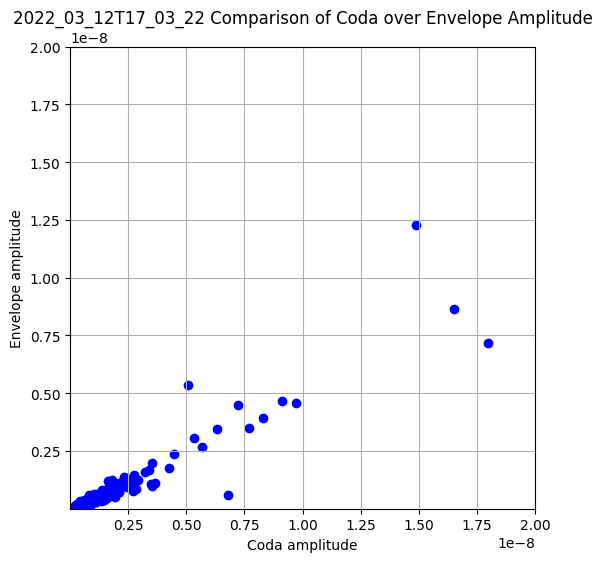

In [22]:
coda = [coda_amp[station] for station in common_stations]
envelope = [envelopes_amps[station] for station in common_stations]

plt.figure(figsize=(6, 6))
plt.scatter(coda, envelope, color='b', label='Common Stations coda over envelope amplitude')

plt.xlabel('Coda amplitude')
plt.ylabel('Envelope amplitude')
plt.title(f'{time_string} Comparison of Coda over Envelope Amplitude')

#for station, x, y in zip(common_stations, coda, envelope):
#    plt.annotate(station, (x, y), textcoords="offset points", xytext=(5, 5), ha='right')

#plt.legend()
plt.xlim([1e-14,20e-9])
plt.ylim([1e-14,20e-9])
plt.grid(True)
plt.show()

344
344
slope is  2.0981587798953796


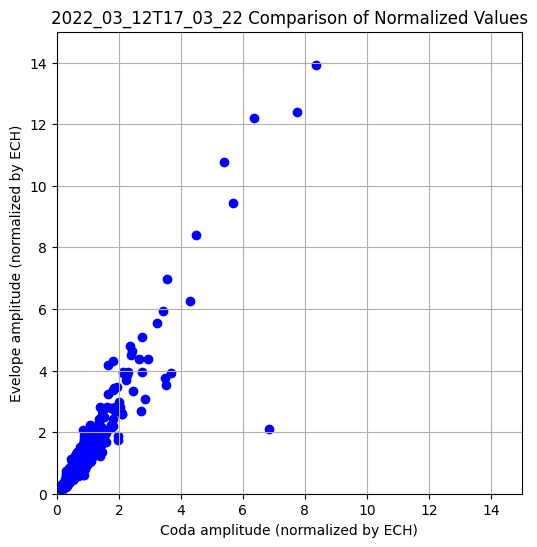

In [25]:
reference_station = 'ECH'

if reference_station in coda_amp and reference_station in envelopes_amps:
    ref_coda = coda_amp[reference_station]
    ref_envelope = envelopes_amps[reference_station]
    common_stations = set(coda_amp.keys()) & set(envelopes_amps.keys()) - {reference_station}

    coda_ratio = [coda_amp[station] / ref_coda for station in common_stations]
    envelope_ratio = [envelopes_amps[station] / ref_envelope for station in common_stations]
    print(len(coda_ratio))
    print(len(envelope_ratio))
    coef1 = np.polyfit(coda_ratio,envelope_ratio,1)
    print("slope is ", coef1[0])
    plt.figure(figsize=(6, 6))
    plt.scatter(coda_ratio, envelope_ratio, color='b', label='Common Stations')

    plt.xlabel(f'Coda amplitude (normalized by {reference_station})')
    plt.ylabel(f'Evelope amplitude (normalized by {reference_station})')
    plt.title(f'{time_string} Comparison of Normalized Values')

    #for station, x, y in zip(common_stations, coda_ratio, envelope_ratio):
    #    plt.annotate(station, (x, y), textcoords="offset points", xytext=(5, 5), ha='right')

    #plt.legend()
    plt.xlim([0,15])
    plt.ylim([0,15])

    plt.grid(True)
    plt.show()

else:
    print(f"Reference station {reference_station} not found in both dictionaries.")


In [26]:


def update_event_file(file_path, event_name, station_data):
    """
    Update a CSV file with station-event data.
    
    :param file_path: Path to the CSV file.
    :param event_name: Name of the event (prefix for column names).
    :param station_data: Dictionary with station names as keys and tuples of values for the event.
    """
    # Load existing data if the file exists
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0)
    else:
        df = pd.DataFrame()

    col1 = f"{event_name}_coda"
    col2 = f"{event_name}_envelope"
    
    for col in [col1, col2]:
        if col not in df.columns:
            df[col] = 0.0 
    for station in station_data.keys():
        if station not in df.index:
            df.loc[station] = [0.0] * len(df.columns)

    df = df.astype({col1: float, col2: float})

    for station, (value1, value2) in station_data.items():
        df.at[station, col1] = float(value1)
        df.at[station, col2] = float(value2)

    df.to_csv(file_path)
    print(f"Updated {file_path} with event '{event_name}'.")



#coda_envelope_amp_dict = {station: (coda_amp[station], envelopes_amps[station]) for station in common_stations}

file_path = "envelope350_470_coda440_460.csv"
event_name = time_string

update_event_file(file_path, event_name, coda_envelope_amp_dict)





Updated envelope350_470_coda440_460.csv with event '2022_03_12T17_03_22'.
